In [1]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from langchain_core.tools import tool
from langgraph.graph import StateGraph,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from typing_extensions import TypedDict
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [3]:
@tool(description="returning the stock price")
def get_stock_price(symbol: str) -> float:
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_stock_price]

llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

In [4]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)

graph = builder.compile()


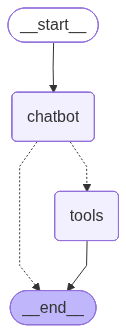

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
state = graph.invoke({"messages": [{"role": "user", "content": "What is the price of AAPL stock right now?"}]})
print(state["messages"][-1].content)

100.4


In [41]:
state = graph.invoke({"messages": [{"role": "user", "content": "Who invented theory of relativity? print person name only"}]})
print(state["messages"][-1].content)

Albert Einstein


In [42]:
msg = "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]})
print(state["messages"][-1].content)

200.3
